### 0. Import libraries

In [76]:
# Torch and Torchlightning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

# pytorch model summary 
!pip install pytorch_model_summary
from pytorch_model_summary import summary

# Sklearn for onehote encoding
from sklearn.preprocessing import LabelEncoder

# pandas
import pandas as pd

#Plotting tools 
import matplotlib.pyplot as plt

# some other utility modules
import random
import ast
import os

# Imports for SandiaPV
from pvlib import irradiance, temperature, pvsystem
from sandiapv_energy_prediction import *

C:\Users\denni\AppData\Local\Temp\ipykernel_24104\1537358420.py:19: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. Define model

In [2]:
class EnergyPredictionModel(nn.Module):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size):
        super(EnergyPredictionModel, self).__init__()
        self.dynamic_feature_size = dynamic_feature_size
        self.static_feature_size = static_feature_size
        self.hidden_size = hidden_size
        
        # LSTM module for dynamic features
        self.dynamic_rnn = nn.LSTM(input_size=dynamic_feature_size, hidden_size=hidden_size, batch_first=True)
        
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_size + static_feature_size, hidden_size)  
        self.relu = nn.ReLU() 

        # Batch Normalization layer after the first FC layer and activation
        self.bn1 = nn.BatchNorm1d(hidden_size) 
        
        # Second Fully connected layer
        self.fc2 = nn.Linear(hidden_size, 3)
    
    def forward(self, dynamic_features, static_features):
        # Pass dynaamic features through LSTM
        _, (h_n, _) = self.dynamic_rnn(dynamic_features)
        h_n = h_n.squeeze(0)  
        
        # Concatenate dynamic features with static features
        concatenated_features = torch.cat((h_n, static_features), dim=1)
        
         # Pass concatenated features through first fully connected layer
        x = self.fc1(concatenated_features)
        x = self.relu(x)  

        # Apply batch normalization
        #x = self.bn1(x)
        
        # Pass through the second fully connected layer
        output = self.fc2(x)
        return output

## 2. Define training class


In [3]:

class TrainEnergyPrediction(pl.LightningModule):
    def __init__(self,dynamic_feature_size, static_feature_size, hidden_size, learning_rate=1e-3):
        super().__init__()
        self.model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size)
        self.loss_fn = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
        self.learning_rate = learning_rate
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch):
        x_dynamic,x_static, y = batch
        y_pred = self.model(x_dynamic,x_static)
        loss = self.loss_fn(y_pred, y)
        self.log('train_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer

## 2. Prepare data

In [79]:
weather_data = load_weather_data('dataset/historical_weather.csv')
weather_data.index = pd.to_datetime(weather_data['timestamp'])
    
# Define location
site_location = location.Location(latitude=52.52, longitude=13.4050, altitude=34, tz='Europe/Berlin')

# Generate random panels
seed(0)
panels = generate_random_panels(3)
# - variables for random panels (ranges etc.)




# Initialize the dataset
dataset = EnergyDataset(weather_data, panels)
    
# Initialize the data loader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    


Static Inputs: tensor([[  0.,  29., 197.,   0.],
        [  0.,  29., 197.,   0.],
        [  0.,  29., 197.,   0.],
        [  0.,  29., 197.,   0.],
        [  0.,  29., 197.,   0.],
        [  0.,  29., 197.,   0.],
        [  0.,  29., 197.,   0.],
        [  0.,  29., 197.,   0.],
        [  0.,  29., 197.,   0.],
        [  0.,  29., 197.,   0.]])
Dynamic Inputs Shape: torch.Size([10, 24, 5])
Outputs: tensor([[ 27.3212,  11.0758,   2.6209],
        [ 10.1455,  11.0385,   1.9369],
        [179.0163,  10.2118,   2.8045],
        [167.0186,  10.4770,   3.3568],
        [121.1558,  10.3375,   2.9951],
        [ 53.6229,  10.2460,   1.7764],
        [129.5818,  11.3477,   3.1452],
        [ 23.8356,  11.1913,   3.1833],
        [ 29.3894,  11.4144,   1.7982],
        [ 48.2523,  11.0218,   2.3527]])
Static Inputs: tensor([[  0.,  29., 197.,   0.],
        [  0.,  29., 197.,   0.],
        [  0.,  29., 197.,   0.],
        [  0.,  29., 197.,   0.],
        [  0.,  29., 197.,   0.],
   

#### 2.2 add real measurement data to the synthetic dataset

## 3. Plot dataset

In [80]:
# Initialize the model
dynamic_feature_size = 5
static_feature_size = 4
hidden_size = 32
learning_rate = 1e-3
model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size)
    
# Initialize the Lightning module
train_module = TrainEnergyPrediction(dynamic_feature_size,static_feature_size,learning_rate)
train_module.model = model  

print(summary(model,dynamic_feature_size,static_feature_size,hidden_size, show_input=False, show_hierarchical=False))

# Set up TensorBoard logger
log_dir = "tb_logs/my_model"
print("Log directory contents:", os.listdir(log_dir))
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=10)
    
# Fit the model to the training data
trainer.fit(train_module, data_loader)

TypeError: hidden_size should be of type int, got: float

## 5. Inspect performance

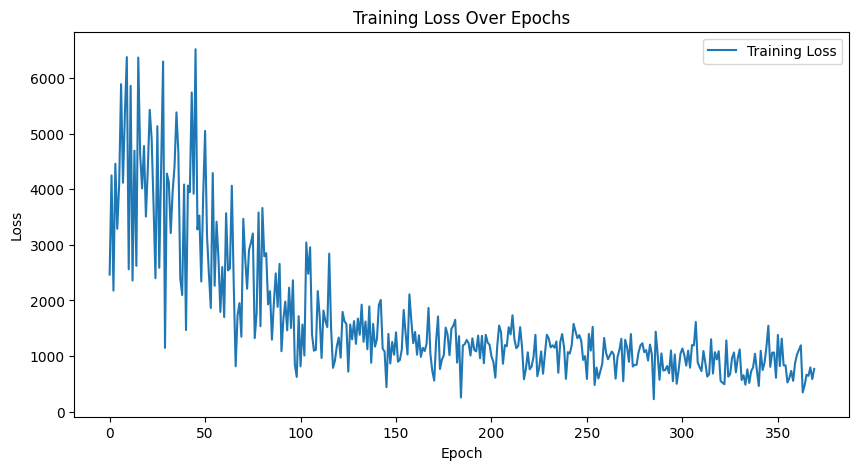

In [10]:
# After training
plt.figure(figsize=(10, 5))
plt.plot(train_module.train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## 5. Evaluate model

In [89]:
#Launch tensorboard for advanced training insights.

%reload_ext tensorboard
%tensorboard --logdir tb_logs/my_model

Launching TensorBoard...

### Use model

tensor([[124.7469,  11.7178,   3.4706]]) torch.Size([1, 3])
[[124.74691    11.717762    3.4706259]] (1, 3)


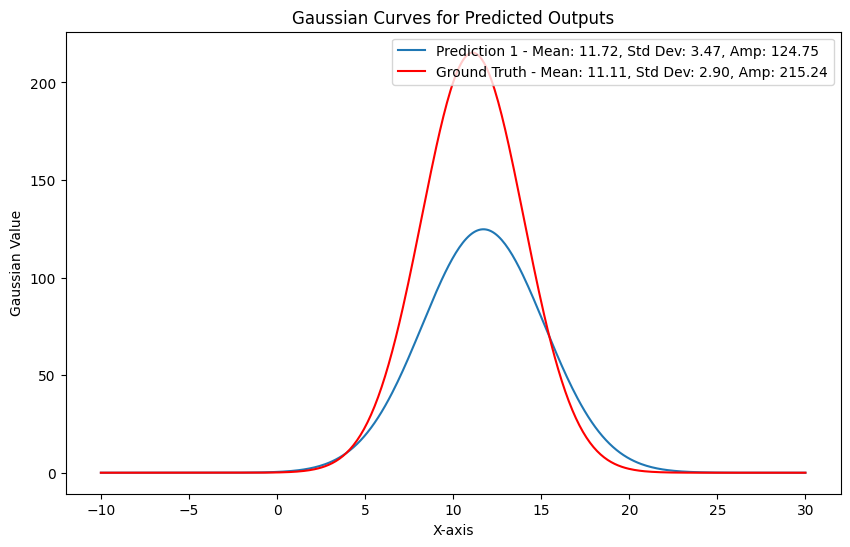

In [11]:
# Load the trained model
trained_model = train_module 
trained_model.eval() 

# Get a single sample from the data loader
sample_dynamic, sample_static, ground_truth = next(iter(data_loader))
sample =5
# Predict using a single example
with torch.no_grad():
    predictions = trained_model(sample_dynamic[sample].unsqueeze(0), sample_static[sample].unsqueeze(0))
print(predictions,predictions.shape)

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to plot Gaussian curves
def plot_gaussian(x, predictions,ground_truth, labels):
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, label in enumerate(labels):
        a, b, c = predictions[i]
        y = gaussian(x, a, b, c)
        ax.plot(x, y, label=f'{label} - Mean: {b:.2f}, Std Dev: {c:.2f}, Amp: {a:.2f}')
    
     # Plot ground truth Gaussian curves
    gt_a, gt_b, gt_c = ground_truth[0]
    gt_y = gaussian(x, gt_a, gt_b, gt_c)
    ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
    

    ax.set_title('Gaussian Curves for Predicted Outputs')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Gaussian Value')
    ax.legend()
    plt.show()

# Prepare x-axis for the plot
x_values = np.linspace(-10, 30, 400)

# Reshape predictions if necessary and convert to numpy if still in tensor form
predictions = predictions.squeeze().numpy().reshape(1, -1)
predictions = predictions
print(predictions, predictions.shape)
ground_truth = ground_truth[sample].squeeze().numpy().reshape(1, -1)
# Plot the Gaussian curve for the predicted values
plot_gaussian(x_values, predictions,ground_truth, labels=["Prediction 1"])